In [1]:
import spacy
import nltk
import re
import string
import pandas as pd
import numpy as np
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
import json
%matplotlib inline
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer



In [39]:
newline = []

textstring = ''
with open('Hansard_preCovid.csv', 'r', encoding='utf-16-le') as inp, open('newtextfile.txt', 'w') as out:
    for line in inp:
      newline.append(re.findall(r'"(.*)"', line))
      
temp = pd.Series(newline)

initialDF_preCovid = pd.DataFrame({'Text': temp})
clearWords = stopwords.words('english')
new_Stopwords = ['in', 'the', 'said', 'like','must', 'many', 'also', '(', ')', ',', '\'', ':', '.', '?', ']', '[', '-', 'mr.']
clearWords.extend(new_Stopwords)
lemma= WordNetLemmatizer()
table = str.maketrans('', '', string.punctuation)
initialDF_preCovid['Text'] = initialDF_preCovid['Text'].astype(str).str.lower()
initialDF_preCovid['Text'] = initialDF_preCovid['Text'].str.replace("|".join([r"^.*?speaker,", r"^.*?chair," ]), ' ', regex=True)
initialDF_preCovid['text_tokens'] = initialDF_preCovid['Text'].apply(word_tokenize)
initialDF_preCovid['text_tokens'] = initialDF_preCovid['text_tokens'].apply(lambda x: [item for item in x if item not in clearWords])
initialDF_preCovid['text_tokens'] = initialDF_preCovid['text_tokens'].apply(lambda x: [lemma.lemmatize(item) for item in x]) 
initialDF_preCovid['text_tokens'] = initialDF_preCovid['text_tokens'].apply(lambda w: [item.translate(table) for item in w])
# do we love me or what? isn't this join thing amazing?


In [3]:
initialDF_midCovid= pd.read_csv('Hansard_mid_covid.csv', sep=',', encoding='utf-16-le')
initialDF_midCovid.drop(['Publication', 'First Name', 'Last Name','Constituency', 'Province', 'Date', 'Time', 'Page'], axis=1)
clearWords = stopwords.words('english')
new_Stopwords = ['in', 'the', 'said', 'like','must', 'many', 'also', '(', ')', ',', '\'', ':', '.', '?', ']', '[', '-', 'mr.']
clearWords.extend(new_Stopwords)
lemma= WordNetLemmatizer()

table = str.maketrans('', '', string.punctuation)


initialDF_midCovid['Text'] = initialDF_midCovid['Text'].astype(str).str.lower()
initialDF_midCovid['Text'] = initialDF_midCovid['Text'].str.replace("|".join([r"^.*?speaker,", r"^.*?chair," ]), ' ', regex=True)
initialDF_midCovid['text_tokens'] = initialDF_midCovid['Text'].apply(word_tokenize)
initialDF_midCovid['text_tokens'] = initialDF_midCovid['text_tokens'].apply(lambda x: [item for item in x if item not in clearWords])
initialDF_midCovid['text_tokens'] = initialDF_midCovid['text_tokens'].apply(lambda x: [lemma.lemmatize(item) for item in x]) 
initialDF_midCovid['text_tokens'] = initialDF_midCovid['text_tokens'].apply(lambda w: [item.translate(table) for item in w])

# do we love me or what? isn't this join thing amazing?

In [17]:

# finding bigrams and trigrams pre-covid 

gram_wordlist = ['worker' , 'immigration',
                 'caregiver', 'canada', 'canadian', 'temporary', 'migrant', 'foreign', 'labour', 'committee', 'family', 'immigrant', 
                 'industry', 'farm','farmer', 'skill', 'skilled', 'bill', 'resident', 'farmer', 'agriculture', 'housing',
                   'employment', 'insurance' ,'employee' , 'harassment', 'residency' ,'residence', 'social', 'development', 'farming', 'program']
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents(initialDF_preCovid['text_tokens'])
finder.apply_freq_filter(15)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)


trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents(initialDF_preCovid['text_tokens'])
finder.apply_freq_filter(15)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = True, inplace = True)
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = True, inplace = True)
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in clearWords or bigram[1] in clearWords:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in clearWords or trigram[-1] in clearWords or trigram[1] in clearWords:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 1, axis = 1)][:200]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi >1, axis = 1)][:200]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if x[0] in gram_wordlist or x[1] in gram_wordlist or x[-1] in gram_wordlist ]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if x[0] in gram_wordlist or x[1] in gram_wordlist or x[-1] in gram_wordlist]

In [18]:
trigrams

['refugee citizenship canada',
 'foreign worker program',
 'minister immigration refugee',
 'committee citizenship immigration',
 'immigration refugee citizenship',
 'temporary foreign worker',
 'canada pension plan',
 'livein caregiver program',
 'atlantic immigration pilot',
 'labour market impact',
 'standing committee citizenship',
 'global skill strategy']

In [19]:


# Concatenate n-grams
def replace_ngram(x): 
    #first convert to string from list, then add the bigram and trigram strings. 
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split(' ')))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split(' ')))
    return x


In [20]:
initialDF_midCovid.Text = initialDF_midCovid.Text.map(lambda x: replace_ngram(x))

#initialDF_midCovid['Text'] = initialDF_midCovid['Text'].apply(lambda w: [item.translate(table) for item in w])
initialDF_midCovid['Text'] = initialDF_midCovid['Text'].apply(word_tokenize)
initialDF_midCovid['Text'] = initialDF_midCovid['Text'].apply(lambda x: [item for item in x if item not in clearWords])
initialDF_midCovid['Text'] = initialDF_midCovid['Text'].apply(lambda x: [lemma.lemmatize(item) for item in x])
initialDF_midCovid['Text'] = initialDF_midCovid['Text'].apply(lambda x: [item for item in x if len(item) > 2])


In [33]:
# Filter for only nouns adjectives and verbs
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN', 'NNS', 'JJ', 'JJS','JJR', 'RB', 'RBR', 'RBS', 'VBD', 'VBP', 'VBG', 'VBN', 'VBZ']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

In [22]:
final_text = initialDF_midCovid.Text.map(noun_only)

LDA Model midCovid

In [ ]:
dictionary = corpora.Dictionary(final_text)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_text]
coherence = []
for k in range(5,25):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=20,\
                   iterations=100, chunksize = 1000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_text,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

In [ ]:

x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.savefig('fig1')
plt.show()

In [ ]:


Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=12, id2word = dictionary, passes=35,\
               iterations=60,  chunksize = 1000, eval_every = None, random_state=0)


ldamodel.show_topics(16,50, formatted=False)

In [ ]:
topic_data =  pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'mmds')
pyLDAvis.display(topic_data)

In [ ]:
#to extract the words for a given lambda 

lambd = 0.09
all_topics = {}
num_terms = 45

for i in range(1,13):
     topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
     topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
     all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values



pd.DataFrame(all_topics).T



PRE-COVID LDA

In [38]:
initialDF_preCovid.Text = initialDF_preCovid.Text.map(lambda x: replace_ngram(x))

#initialDF_midCovid['Text'] = initialDF_midCovid['Text'].apply(lambda w: [item.translate(table) for item in w])
initialDF_preCovid['Text'] = initialDF_preCovid['Text'].apply(word_tokenize)
initialDF_preCovid['Text'] = initialDF_preCovid['Text'].apply(lambda x: [item for item in x if item not in clearWords])
initialDF_preCovid['Text'] = initialDF_preCovid['Text'].apply(lambda x: [lemma.lemmatize(item) for item in x])
initialDF_preCovid['Text'] = initialDF_preCovid['Text'].apply(lambda x: [item for item in x if len(item) > 3])


TypeError: expected string or bytes-like object

In [34]:
pre_covid_text = initialDF_preCovid.Text.map(noun_only)

In [25]:
dictionary = corpora.Dictionary(pre_covid_text)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in pre_covid_text]
coherence = []
for k in range(5,25):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=25,\
                   iterations=200, chunksize = 1000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=pre_covid_text,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24


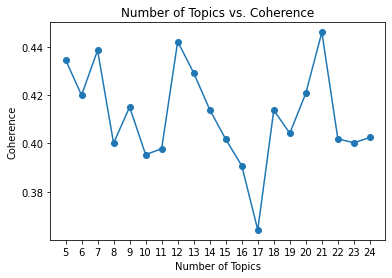

In [26]:

x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.savefig('fig2')
plt.show()

In [30]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda(doc_term_matrix, num_topics=21, id2word = dictionary, passes=35,\
               iterations=200,  chunksize = 1000, eval_every = None, random_state=0)


ldamodel2.show_topics(20,50, formatted=False)

KeyboardInterrupt: 

In [31]:


ldamodel2.show_topics(20,50, formatted=False)

[(16,
  [('trade', 0.022546448),
   ('tpp', 0.012100768),
   ('agreement', 0.009978398),
   ('government', 0.008976576),
   ('say', 0.008562467),
   ('concern', 0.007146676),
   ('building', 0.0071465713),
   ('negative', 0.007083113),
   ('heard', 0.006473622),
   ('thing', 0.0057307854),
   ('hear', 0.0055680564),
   ('member', 0.0054187155),
   ('see', 0.0043148906),
   ('colleague', 0.00431485),
   ('anti-trade', 0.0043121176),
   ('time', 0.004144512),
   ('positive', 0.004120201),
   ('way', 0.0038550694),
   ('international', 0.003388171),
   ('canadian', 0.0031867062),
   ('committed', 0.0031297395),
   ('canada', 0.0030239914),
   ('committee', 0.0028990598),
   ('new', 0.002899049),
   ('want', 0.002899034),
   ('party', 0.0028990316),
   ('study', 0.0028990244),
   ('real', 0.0028990163),
   ('particular', 0.0028990137),
   ('parliamentary', 0.0028990086),
   ('look', 0.0028990076),
   ('sector', 0.002899007),
   ('afraid', 0.002899004),
   ('secretary', 0.0028990025),
   ('

In [32]:
topic_data =  pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix, dictionary, mds = 'tsne')
pyLDAvis.display(topic_data)

c:\Users\Kriti Kapoor\AppData\Local\Programs\Python\Python38\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
#to extract the words for a given lambda 

lambd = 0.9
all_topics = {}
num_terms = 45

for i in range(1,13):
     topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
     topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
     all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values



pd.DataFrame(all_topics).T

In [ ]:
ldamodel2.show_topic(8,100)